In [1]:
import sys
sys.path.append('../code')

from SamplingWalk import *
from labs import *
import dynamiqs as dq
import numpy as np

import networkx as nx
import matplotlib.pyplot as plt

# Problem: Low Autocorrelation Binary Sequences (LABS)

The Low Autocorrelation Binary Sequences (LABS) is a quartic combinatorial problem. Given a sequence $s=(s_1,\cdots, s_n)$ with $s_i=\pm 1$, one aims at minimizing its energy:
$$E(s)=\sum_{k=1}^{n-1}\left(\sum_{i=1}^{n-k}s_is_{i+k}\right)^2.$$
Equivalently, the problem can be reduced to maximizing the merit factor $F(s)=n^2/2E(s)$.

## Problem generation

We generate the instance of LABS on $n$ qubits. Note that we can go from the spin $s$ to integer $i$ representation with:

$$i = \sum_{k=1}^{n} \frac{1 - s_k}{2} \, 2^{\,n-k}, 
\quad s = (s_1, s_2, \dots, s_n) \in \{\pm 1\}^n$$

In [2]:
# Number of Ising variables (number of qubits)
n = 8

We first use a brute-force approach to compute the solutions of the problem to compare with the results obtained with SamBa GQW.

In [3]:
# Compute cost for all bitstrings
cost_values = []
for i in range(2**n):
    spin = int_to_spin(i,n)         # convert integer to binary vector
    cost_val = labs_energy(spin)
    cost_values.append(cost_val)

# Normalize to [0,1] (1 = minimum cost, 0 = maximum cost)
cost_values = np.array(cost_values)
min_val = cost_values.min()
max_val = cost_values.max()
normalized_values = 1 - (cost_values - min_val) / (max_val - min_val)

# Create the dictionary: each key is a computational basis state (integer version) and the value is its quality (1 for optimal solutions, 0 for worst)
cost_quality_dict = {i: normalized_values[i] for i in range(2**n)}

We visualize the cost function on the solution space ($n$-dimensional hypercube) where the color of the vertices depends on their quality, which is 1 for optimal solutions and 0 for worst.

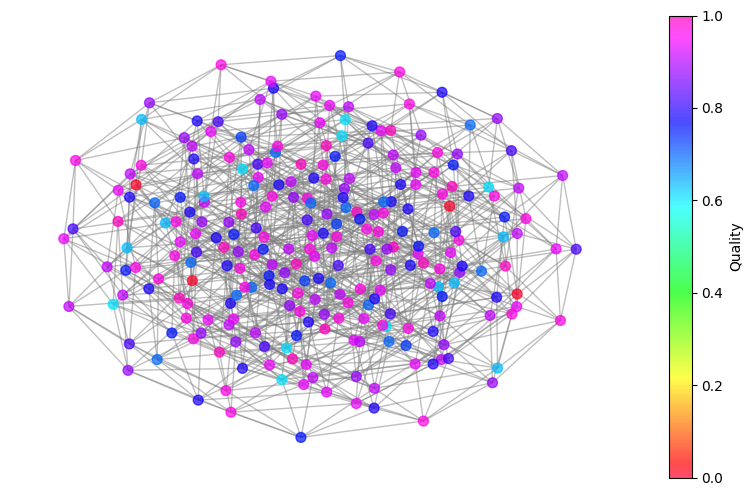

In [4]:
# Solution graph (each node of this hypercube corresponds to a computational basis state, i.e. a decision)
mixer_graph = nx.hypercube_graph(n) # hypercube since we use X-mixer for this problem

# Map vertex -> value
node_colors = [cost_quality_dict[int("".join(map(str, node)), 2)] for node in mixer_graph.nodes()]

cmap = plt.cm.gist_rainbow

# Create figure + axes explicitly
fig, ax = plt.subplots(figsize=(10, 6))

# Layout (spring or shell works well)
pos = nx.spring_layout(mixer_graph, seed=42)

# Draw graph
nodes = nx.draw_networkx_nodes(
    mixer_graph, pos, node_color=node_colors, cmap=cmap,
    vmin=0, vmax=1, node_size=50, ax=ax, alpha=0.7
)

nx.draw_networkx_edges(
    mixer_graph, pos,
    edge_color="gray",   # set all edges to gray
    alpha=0.5,
    ax=ax
)

# Add colorbar linked to nodes
cbar = fig.colorbar(nodes, ax=ax)
cbar.set_label("Quality")

ax.axis("off")
plt.show()

## SamBa GQW: classical part

We create an instance of SamBa-GQW for MaxCut with $X$-mixer, then we perform the sampling protocol and compute the mean of the sampled energy gaps.

In [5]:
# Creation of instance of SamBa GQW

use_qutip = False # QuTip or Dynamiqs

if use_qutip:
    mixer = nx.adjacency_matrix(nx.hypercube_graph(n)).todense() # dense representation
else:
    mixer = dq.sparsedia_from_dict(hypercube_adjacency_sparse_final(n)) # sparse representation

samba_gqw = SamplingWalk(n,
                      cost=labs_energy, # MaxCut cost function
                      mixer=mixer, # Mixer (here n-dimensional hypercube)
                      use_qutip=True, # We use Dynamiqs
                      use_density_matrix=False, # State vector representation
                      convert_input_cost_fun=int_to_spin, # Function to convert integer to binary vectors
            )

# Sampling protocol
q = n**2 # Quadratic sampling
neighbors_fun = hamming_neighbors # X-mixer (hypercube) neighboring function
samba_gqw.sampling_protocol(q=q, neighbors_fun=neighbors_fun)
samba_gqw.compute_mean_gaps()

We visualize the vertices (states) sampled on the solution graph.

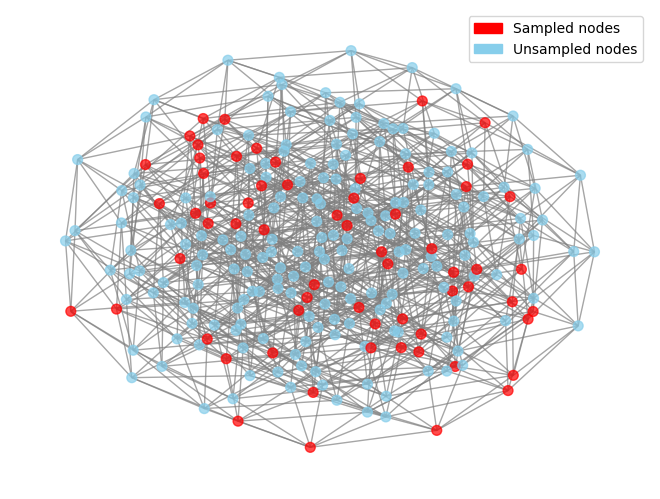

In [6]:
import matplotlib.patches as mpatches

# Map tuple nodes → integers
node_int_map = {node: int("".join(map(str, node)), 2) for node in mixer_graph.nodes()}

# Choose special nodes to highlight (integers from your sampler)
sampled_nodes = samba_gqw.sampled_states  # already integers

# Assign colors: red for special, skyblue otherwise
node_colors = [
    "red" if node_int_map[node] in sampled_nodes else "skyblue"
    for node in mixer_graph.nodes()
]

# Draw without labels
nx.draw(
    mixer_graph, pos,
    with_labels=False,
    node_color=node_colors,
    node_size=50,
    edge_color="gray", alpha=0.7
)
# Création de la légende
red_patch = mpatches.Patch(color='red', label='Sampled nodes')
blue_patch = mpatches.Patch(color='skyblue', label='Unsampled nodes')
plt.legend(handles=[red_patch, blue_patch])

plt.show()

### Interpolation of $\Gamma$

We construct the time-dependent hopping rate.

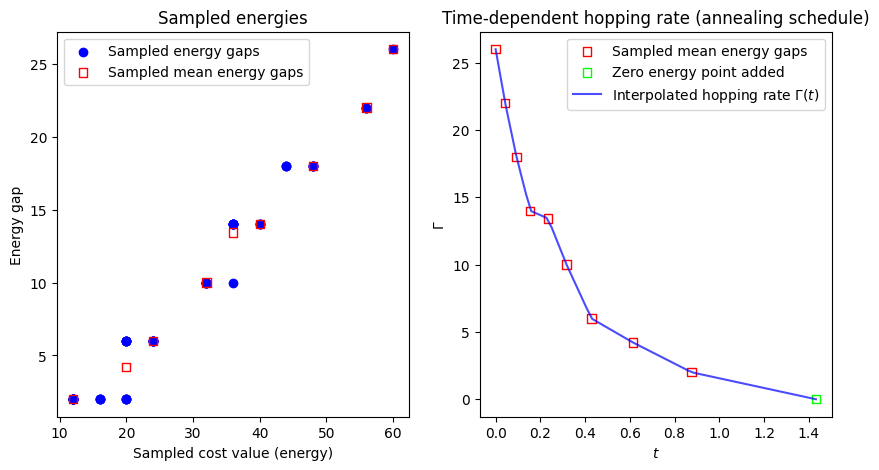

In [7]:
# Interpolation
samba_gqw.interpolate(dt=n**2)

# Create a figure with two subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# --- First plot ---
x_values = [val[0] for val in samba_gqw.sample.values()]
y_values = [val[1]/samba_gqw.local_mixer_gap for val in samba_gqw.sample.values()]

x_temp = samba_gqw.energies.copy()
new_temp = samba_gqw.np.concatenate([samba_gqw.np.array([samba_gqw.energies[0]]), x_temp])

# Scatter des cercles bleus (points "Sampled energy gaps")
axes[0].scatter(x_values, y_values, color='blue', label='Sampled energy gaps')

# Scatter des carrés rouges (hollow)
axes[0].scatter(samba_gqw.energies, samba_gqw.mean_gaps[::-1][1:], marker='s', facecolors='none', edgecolors='red', label="Sampled mean energy gaps")

axes[0].set_xlabel('Sampled cost value (energy)')
axes[0].set_ylabel('Energy gap')
axes[0].set_title('Sampled energies')
axes[0].legend()

# --- Second plot ---
# Scatter all points except last with hollow red squares
axes[1].scatter(samba_gqw.gap_dt[:-1], samba_gqw.mean_gaps[:-1], marker='s', facecolors='none', edgecolors='red', label='Sampled mean energy gaps')

# Scatter the last point in green (hollow)
axes[1].scatter(samba_gqw.gap_dt[-1:], samba_gqw.mean_gaps[-1:], marker='s', facecolors='none', edgecolors='lime', label='Zero energy point added')

# Plot interpolated hopping
axes[1].plot(samba_gqw.t_list, samba_gqw.hopping, color='blue', linestyle='-', linewidth=1.5, alpha=0.7, label="Interpolated hopping rate $\Gamma(t)$")

axes[1].set_xlabel('$t$')
axes[1].set_ylabel('$\Gamma$')
axes[1].set_title('Time-dependent hopping rate (annealing schedule)')
axes[1].legend()

plt.show()


## SamBa GQW: quantum part
We now solve the problem using SamBa GQW with the Hamiltonian evolution (continuous version).

### Hamiltonian evolution

In [8]:
# We perform the Hamiltonian evolution
results = samba_gqw.evolve()

# We extract the results
if samba_gqw.use_qutip:
    results_array = np.array([state.full() for state in results.states]) # array of quantum states
    times = results.times # values of evaluated time
else:
    results_array = np.array([state.to_numpy() for state in results.states]) # array of quantum states
    times = results.tsave # values of evaluated time

#### Results visualization

We compute several metrics for analysis purposes.

In [9]:
from performance_metrics import *

rank_dict = rank_solutions_by_quality(cost_quality_dict)
prob_over_time = [(np.abs(state)**2).reshape(-1) for state in results_array]
distribution_quality_over_time = [distribution_quality(pr,list(cost_quality_dict.values())) for pr in prob_over_time]
probabilities_per_rank_over_time = [[np.sum(pr[rank_dict[r]]) for pr in prob_over_time] for r in list(rank_dict.keys())]
patricipation_ratio_over_time = 1 / (2**n * np.sum(np.vstack(prob_over_time)**2, axis=1))

We first plot the several metrics over time.

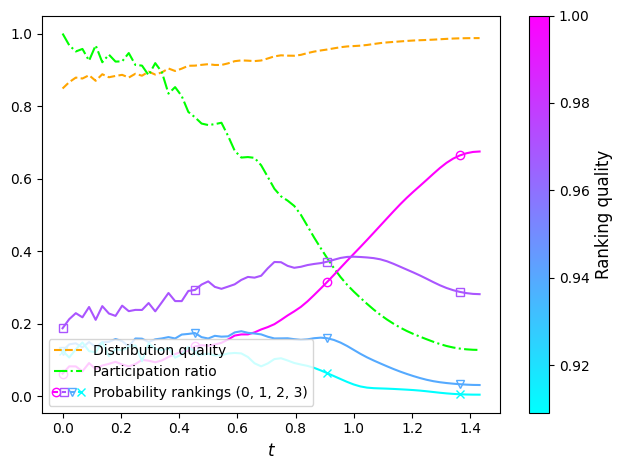

In [10]:
# We select the rankings for which we want to display the measurement probabilities over time
rank_to_display = [0,1,2,3]

# We plot several metrics over time
plot_performance(
    distribution_quality_over_time,
    patricipation_ratio_over_time,
    probabilities_per_rank_over_time,
    times,
    [cost_quality_dict[rank_dict[i][0]] for i in list(rank_dict.keys())],
    rank_list=rank_to_display,
    rank_dict=rank_dict,
    pourcentage=0,
    marker_list=None,
    markevery=20,
    markersize=6,
    show_colorbar=True,
    show_legend=True
)

We then plot the initial and final ranking distributions.

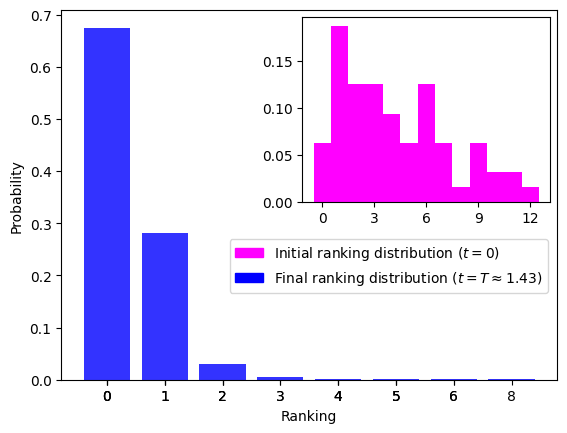

In [11]:
prob_per_rank_init = np.array([probabilities_per_rank_over_time[r][0] for r in list(rank_dict.keys())])
prob_per_rank_final = np.array([probabilities_per_rank_over_time[r][-1] for r in list(rank_dict.keys())])

plot_ranking_distribution(prob_per_rank_final=prob_per_rank_final,
                        prob_per_rank_init=prob_per_rank_init,
                        threshold=1e-3,
                        num_ticks=20,
                        inset_plot_size=50,
                        inset_plot_label='Initial ranking distribution ($t=0$)',
                        main_plot_label=rf'Final ranking distribution ($t=T\approx {round(times[-1],2)}$)',
                        save=False,
                        figname='ranking_distribution.png')

We simulate measurements in the computational basis and we select the best found approximation to be the **measured** state with lowest cost.

The best found assignment is s=194 ([-1 -1  1  1  1  1 -1  1]) of ranking r=0


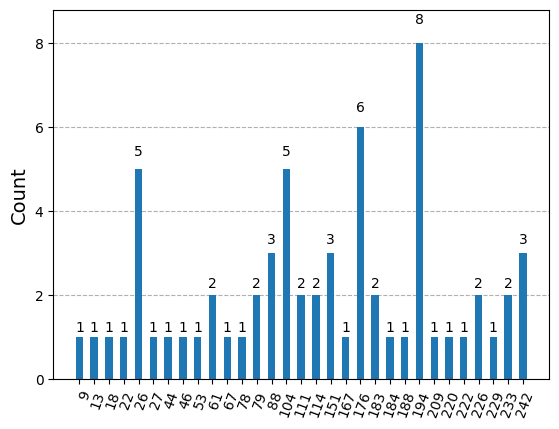

In [12]:
from collections import Counter
from qiskit.visualization import plot_histogram

def sample_measurements(probabilities, k, seed=None):
    """
    Simulate k measurements from a probability distribution.
    
    Args:
        probabilities (array-like): probability vector that sums to 1
        k (int): number of measurements
        seed (int, optional): random seed for reproducibility
    
    Returns:
        dict: {index: count of times measured}
    """
    rng = np.random.default_rng(seed)
    n = len(probabilities)
    outcomes = rng.choice(np.arange(n), size=k, p=probabilities)
    counts = dict(Counter(outcomes))
    return counts

# Number of measurements
n_shots = n**2

# Simulate the measurements
res = sample_measurements(prob_over_time[-1], n_shots, seed=42)

# Keep 
best_found_assigment = min(res.keys(), key=lambda s: labs_energy(int_to_spin(s,n)))
print(f'The best found assignment is s={best_found_assigment} ({int_to_spin(best_found_assigment,n)}) of ranking r={next((key for key, values in rank_dict.items() if best_found_assigment in values))}')
plot_histogram(res)